📚 Case Study: Handwritten Digit Recognition (MNIST)
🔹 Problem

We want a system that can recognize handwritten digits (0–9).

Handwriting often has tiny variations:

- Slight shifts of the pen ✍️

- Extra ink blots 🖤

- Small noise in scanned images 📷

A plain autoencoder may overfit to these small variations and produce unstable hidden features.


Training Autoencoder...
Epoch 1, Loss: 0.0472
Epoch 2, Loss: 0.0202
Epoch 3, Loss: 0.0148
Epoch 4, Loss: 0.0125
Epoch 5, Loss: 0.0111

Training Contractive Autoencoder...
Epoch 1, Loss: 0.0922
Epoch 2, Loss: 0.0641
Epoch 3, Loss: 0.0604
Epoch 4, Loss: 0.0549
Epoch 5, Loss: 0.0470
Epoch 6, Loss: 0.0401
Epoch 7, Loss: 0.0353
Epoch 8, Loss: 0.0326
Epoch 9, Loss: 0.0311
Epoch 10, Loss: 0.0301
Epoch 11, Loss: 0.0293
Epoch 12, Loss: 0.0283
Epoch 13, Loss: 0.0273
Epoch 14, Loss: 0.0266
Epoch 15, Loss: 0.0261
Epoch 16, Loss: 0.0257
Epoch 17, Loss: 0.0253
Epoch 18, Loss: 0.0251
Epoch 19, Loss: 0.0245
Epoch 20, Loss: 0.0237

Visualizing AE reconstructions...


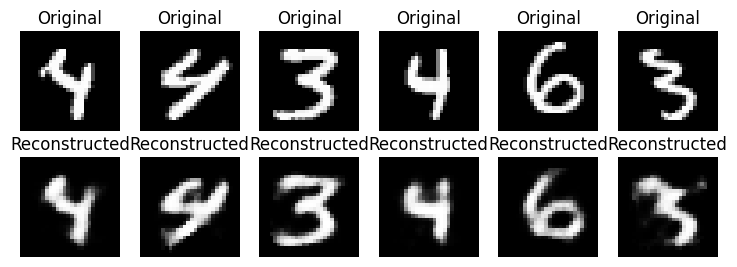


Visualizing CAE reconstructions...


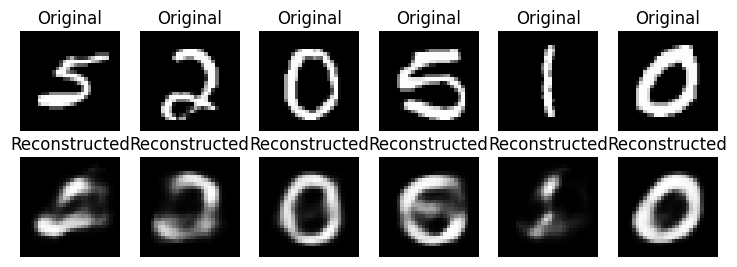

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ===================== Data ======================
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# ===================== Model ======================
class Autoencoder(nn.Module):
    def __init__(self, hidden_dim=32):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

# ===================== Loss ======================
def contractive_loss(x, recon, h, model, lam=1e-4):
    # Reconstruction loss (MSE)
    mse = nn.MSELoss()(recon, x)

    # Get weights of the LAST encoder layer (maps to hidden)
    W = list(model.encoder[2].parameters())[0]  # shape: (hidden_dim, 128)

    # Activation derivative approximation
    h_act = h * (1 - h)   # works if using sigmoid; for ReLU you'd use (h>0).float()

    # Contractive penalty: sum over hidden units
    contractive = torch.sum((h_act.unsqueeze(2) ** 2) * (W ** 2).sum(dim=1))

    return mse + lam * contractive, mse, contractive


# ===================== Training ======================
def train_model(model, use_contractive=False, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for data, _ in train_loader:
            x = data.view(-1, 28*28)
            optimizer.zero_grad()

            recon, h = model(x)
            if use_contractive:
                loss, mse, contr = contractive_loss(x, recon, h, model, lam=1e-3)
            else:
                loss = nn.MSELoss()(recon, x)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Loss: {losses[-1]:.4f}")
    return losses

# ===================== Run AE vs CAE ======================
ae = Autoencoder()
cae = Autoencoder()

print("\nTraining Autoencoder...")
ae_losses = train_model(ae, use_contractive=False, epochs=5)

print("\nTraining Contractive Autoencoder...")
cae_losses = train_model(cae, use_contractive=True, epochs=20)

# ===================== Visualization ======================
def visualize(model, noisy=False):
    dataiter = iter(train_loader)
    images, _ = next(dataiter)
    x = images.view(-1, 28*28)

    if noisy:
        noise = torch.randn_like(x) * 0.2
        x = torch.clamp(x + noise, 0., 1.)

    recon, _ = model(x)
    recon = recon.view(-1, 1, 28, 28).detach()

    fig, axes = plt.subplots(2, 6, figsize=(9,3))
    for i in range(6):
        axes[0, i].imshow(images[i][0], cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        axes[1, i].imshow(recon[i][0], cmap="gray")
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")
    plt.show()

print("\nVisualizing AE reconstructions...")
visualize(ae, noisy=True)

print("\nVisualizing CAE reconstructions...")
visualize(cae, noisy=True)
